<a href="https://colab.research.google.com/github/lizehrhardt/recaptcha/blob/main/import.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount GoogleDrive where datasets are located

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!ls "/content/drive/MyDrive/captcha/large/train"
!pwd

 Bicycle   Bus	 Chimney     Hydrant	  Mountain   Palm    'Traffic Light'
 Bridge    Car	 Crosswalk   Motorcycle   Other      Stairs
/content


Import python packages and declare global variables

In [3]:
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

large_labels = ['Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney', 'Crosswalk', 'Hydrant', 'Motorcycle', 'Mountain', 'Other', 'Palm', 'Stairs', 'Traffic Light']
small_labels = ['Car', 'Crosswalk', 'Hydrant', 'TrafficLight']


In [4]:
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

image_size = 128
batch_size = 32

np_data = 'numpy_data/'

large_train_path = "/content/drive/MyDrive/captcha/large/train"
large_test_path = "/content/drive/MyDrive/captcha/large/val"
small_data_path = "/content/drive/MyDrive/captcha/small"

In [5]:
def save_data(data_dir, file_prefix, labels):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                #img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                img_path = os.path.join(path, img)
                img = keras.preprocessing.image.load_img(img_path, target_size=(image_size, image_size))
                img_arr = keras.preprocessing.image.img_to_array(img)
                img_arr = img_arr/255.0
                #img_arr = cv2.imread(os.path.join(path,img),1)
                #resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                #data.append([resized_arr, class_num])
                data.append([img_arr, class_num])
            except Exception as e:
                print(e)
        np.save(np_data+file_prefix+label, data)
    return np.array(data)

In [6]:
def get_small_data(data_dir):
    data = [] 
    for label in small_labels: 
        path = os.path.join(data_dir, label)
        class_num = small_labels.index(label)
        ctr = 0
        for img in os.listdir(path):
            try:
                #img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                img_path = os.path.join(path, img)
                img = keras.preprocessing.image.load_img(img_path, target_size=(image_size, image_size))
                img_arr = keras.preprocessing.image.img_to_array(img)
                img_arr = img_arr/255.0
                #img_arr = cv2.imread(os.path.join(path,img),1)
                #resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                #data.append([resized_arr, class_num])
                data.append([img_arr, class_num])
            except Exception as e:
                print(e)
        np.save('numpy_data/Small_'+label, data)
    return np.array(data)

In [7]:
def get_large_data(data_dir):
    data = [] 
    for label in large_labels: 
        path = os.path.join(data_dir, label)
        class_num = large_labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img = keras.preprocessing.image.load_img(img_path, target_size=(image_size, image_size))
                img_arr = keras.preprocessing.image.img_to_array(img)
                img_arr = img_arr/255.0
                #resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                #data.append([resized_arr, class_num])
                data.append([img_arr, class_num])
            except Exception as e:
                print(e)
        np.save('numpy_data/Large_'+label, data)
    return np.array(data)

In [10]:
#small_data = save_data(small_data_path,'Small_',small_labels)
large_train_data = save_data(large_train_path,'Large_Train_',large_labels)
large_test_data = save_data(large_test_path,'Large_Test_',large_labels)
#small_data = get_small_data(small_data_path)
large_train_data = get_large_data(large_train_path)
large_test_data = get_large_data(large_test_path)
#bus_test = get_data('../input/traintestsports/Main/test')


FileNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

(6621, 2)
(128, 128, 3)
0


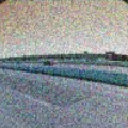

In [ ]:
print(small_data.shape)
img = small_data[1,0]
print(img.shape)
print(small_data[1,1])
cv2_imshow(img)

(4117, 2)
(100, 100, 3)
0


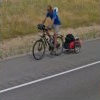

In [ ]:
print(large_test_data.shape)
img = large_test_data[1,0]
print(img.shape)
print(large_test_data[1,1])
cv2_imshow(img)

(8255, 2)
3


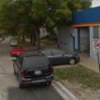

In [ ]:
print(large_train_data.shape)
img = large_train_data[1,0]
print(large_train_data[1,1])
cv2_imshow(img)

In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(directory=large_train_path, target_size=(image_size, image_size))

Found 8255 images belonging to 13 classes.


In [ ]:
validation_datagen = keras.preprocessing.image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_directory(directory=large_test_path, target_size=(image_size, image_size))

Found 4117 images belonging to 13 classes.


In [ ]:
base_model = tf.keras.applications.MobileNet(input_shape=(image_size,image_size,3), include_top=False)

base_model.trainable = False

base_model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(13, activation='sigmoid')
])

base_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 13)                13325     
                                                                 
Total params: 3,242,189
Trainable params: 13,325
Non-trainable params: 3,228,864
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
epochs = 25

steps_per_epoch = np.ceil(train_generator.n / batch_size)
validation_steps = np.ceil(validation_generator.n / batch_size)

history = base_model.fit_generator(generator=train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

base_model.save('MobileNet_TransferLearning_Captcha.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/25
258/258 [==============================] - 123s 470ms/step - loss: 0.2698 - accuracy: 0.2251 - val_loss: 0.3857 - val_accuracy: 0.1790
Epoch 2/25
258/258 [==============================] - 119s 460ms/step - loss: 0.1942 - accuracy: 0.3939 - val_loss: 0.4782 - val_accuracy: 0.2252
Epoch 3/25
258/258 [==============================] - 120s 465ms/step - loss: 0.1815 - accuracy: 0.4516 - val_loss: 0.5184 - val_accuracy: 0.2429
Epoch 4/25
258/258 [==============================] - 120s 463ms/step - loss: 0.1743 - accuracy: 0.4806 - val_loss: 0.5283 - val_accuracy: 0.2516
Epoch 5/25
258/258 [==============================] - 164s 637ms/step - loss: 0.1695 - accuracy: 0.4950 - val_loss: 0.5391 - val_accuracy: 0.2560
Epoch 6/25
258/258 [==============================] - 116s 450ms/step - loss: 0.1658 - accuracy: 0.5070 - val_loss: 0.5411 - val_accuracy: 0.2618
Epoch 7/25
258/258 [==============================] - 117s 456ms/step - loss: 0.1629 - accuracy: 0.5181 - val_loss: 0.5441 -

In [ ]:
model = tensorflow.keras.models.load_model('MobileNet_TransferLearning_Captcha.h5')

In [ ]:
img_height = 128
img_width = 128
num_classes = len(large_labels)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

In [ ]:
epochs=10
history = model.fit(
  large_train_data,
  validation_data = large_test_data,
  epochs= 2
)

ValueError: ignored